
## Packages

In [4]:
import os

import cv2
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

## Input images

In [5]:
INPUT_PATH = '../input/original' # Original image file directory
img_files = glob.glob(INPUT_PATH + '/*.png')
img_files

['../input/original/sample.png']

# Utility functions

In [6]:
# Convert mask image to RLE-encoded data
def mask2enc(mask, n=1): # n is the number of classes
    pixels = mask.T.flatten()
    encs = []
    
    for i in range(1, n+1):
        p = (pixels == i).astype(np.int8)
        
        if p.sum() == 0:
            encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    
    return encs

## Preprocessing image

In [7]:
def preprocessing_img(img, output_type, binarize_threshold=0):
    '''
    imgs: ndarray (width, height, color(BGR))
    output_type: 'GRAY', 'R', 'G', 'B' , 'H', 'S', 'V'
    binarize_threshold(option): 0 to 255 
    '''

    # Gray scale
    img_GRAY = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # RGB
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_R, img_G, img_B = cv2.split(img_RGB)
    # HSV
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_HSV = cv2.GaussianBlur(img_HSV, (9, 9), 3)
    img_H, img_S, img_V = cv2.split(img_HSV)

    # Output type
    if output_type == 'GRAY': img_output = img_GRAY.copy()
    elif output_type == 'R':    img_output = img_R.copy()
    elif output_type == 'G':    img_output = img_G.copy()
    elif output_type == 'B':    img_output = img_B.copy()
    elif output_type == 'H':    img_output = img_H.copy()
    elif output_type == 'S':    img_output = img_S.copy()
    elif output_type == 'V':    img_output = img_V.copy()
    else:
        print('Not preprocessd')
        img_output = img
        
    # Binarize (option)
    if 0 < binarize_threshold <= 255 :
        _, img_output = cv2.threshold(img_output, binarize_threshold, 255, cv2.THRESH_BINARY)
    
    return img_output

## Find contours

In [8]:
def find_contours(img, preprocessing_mode='V', threshold=100, neglect_area=100, neglect_aspect_ratio=0.1):
    '''
    INPUT
    image: (width, heigth, color)
    preprocessing_mode: 'R', 'G', 'B', 'Gray', 'H', 'S', 'V'
    binarize_threshold(option): 0 to 255 
    neglect_area: Threshold to judge that the small area contour is neglected [Number of pixels]
    neglect_aspect_ratio: Threshold to judge that the sharp contour is neglected [Ratio: 0 to 1] 

    # OUTPUT
    contours: list of ndarray
    '''

    # Binarize and Get contours
    img_binary = preprocessing_img(img, output_type=preprocessing_mode, binarize_threshold=threshold)
    contour_candidates, hierarchy = cv2.findContours(img_binary,
                                                     cv2.RETR_LIST,
                                                     cv2.CHAIN_APPROX_NONE)
    
    # Neglect small or sharp contours
    contours = []
    for i in range(len(contour_candidates)):

        # Get the contour origin coordinate, witdh, and length
        x_b, y_b, w, h = cv2.boundingRect(contour_candidates[i])

        # Remove too small, too large, or sharp contours from contour_candidates 
        if w/h > neglect_aspect_ratio and h/w > neglect_aspect_ratio and \
           cv2.contourArea(contour_candidates[i]) > neglect_area and \
           cv2.contourArea(contour_candidates[i]) < (img.shape[0]*img.shape[1])*0.8:

            contours.append(contour_candidates[i])
    
    return contours

## Show contours on image

# of contours: 190


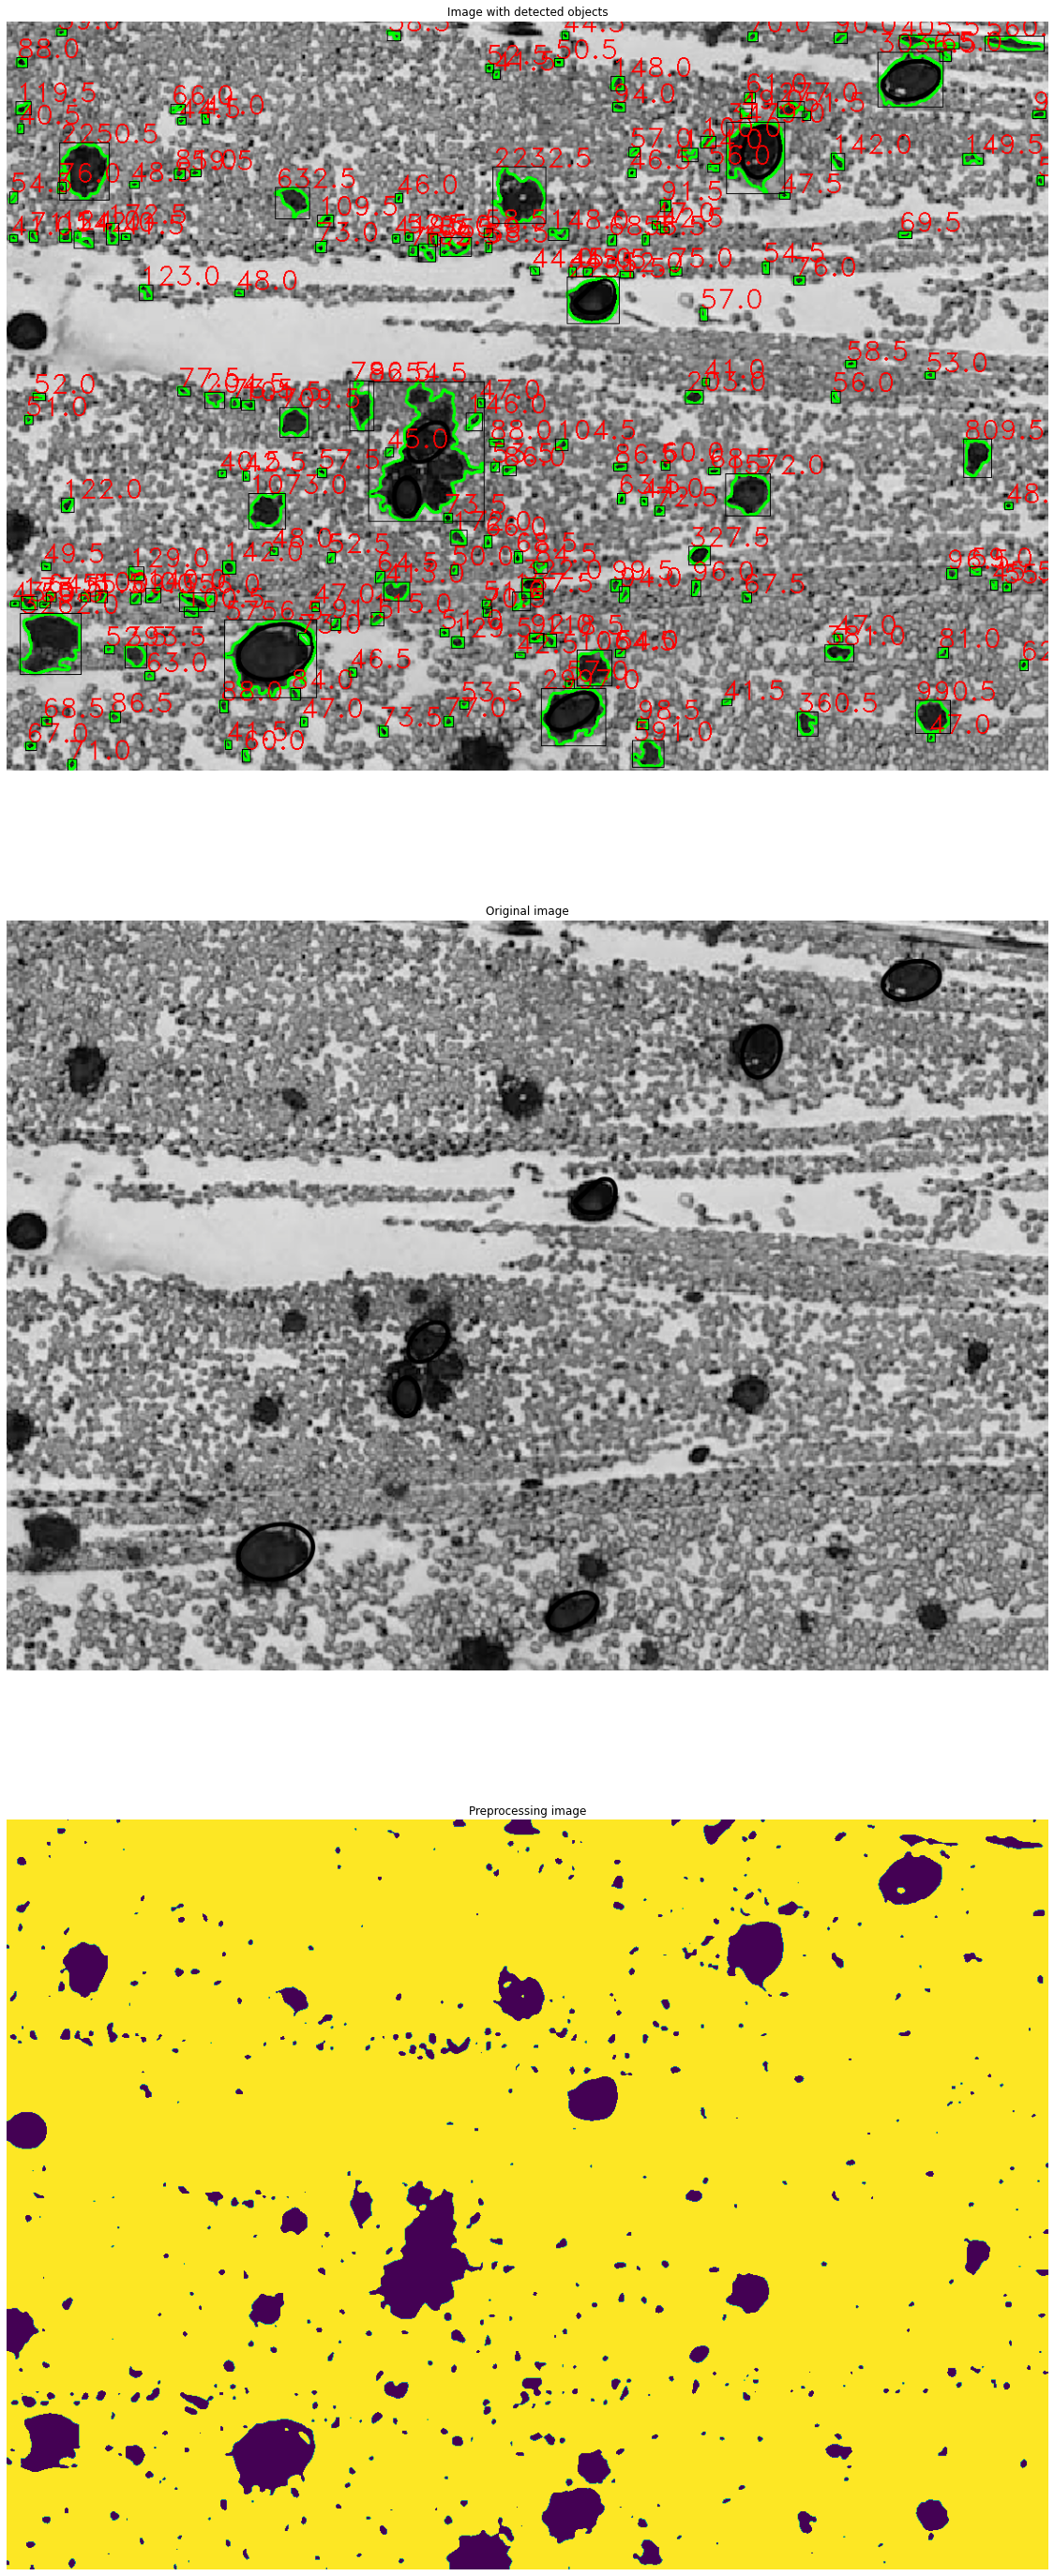

In [30]:
### Parameters to generate mask, changed for each image ###
IMG_NUM = 0 # Displayed image number
SHOW_CONTOUR_LINE = True # Show contours on the raw image
SHOW_CONTOUR_AREA = True # Show area as the number of pixels within coutour line
SHOW_BOUNDING_BOX = True # Show bounding boxes on the raw image
OUTPUT_OF_DIMENSIONS = False # [width, heigth, area] of contours are saved in [image file name].xlsx.
OUTPUT_OF_MASK = True # Contour image is saved as "original_file-mask.jpg".
RLE_ENCODE = True # Mask data is saved as Run-length encoded data
PREPROCESSIONG_MODE = 'V' # Select from 'R', 'G', 'B', 'Gray', 'H', 'S', and 'V'
THRESHOLD = 90 # Upper limit to judge as contours
NEGLECT_AREA = 40 # Lower limit of number of pixels to judge as contours
NEGLECT_ASPECT_RATIO = 0.1 # Lower limit of aspect ratio to judge as contours
############################################################

raw_imgs = [cv2.imread(file) for file in img_files] # Read image as numpy.ndarray (Note cv2.imread reads as "B" "G" "R")
img_RGB = cv2.cvtColor(raw_imgs[IMG_NUM], cv2.COLOR_BGR2RGB)
img_w_contour = img_RGB.copy()
contours = find_contours(img_RGB,
                         preprocessing_mode=PREPROCESSIONG_MODE,
                         threshold=THRESHOLD,
                         neglect_area=NEGLECT_AREA,
                         neglect_aspect_ratio=NEGLECT_ASPECT_RATIO)
img_preprocessed = preprocessing_img(raw_imgs[IMG_NUM],
                                     output_type=PREPROCESSIONG_MODE,
                                     binarize_threshold=THRESHOLD)

if SHOW_CONTOUR_LINE:
    cv2.drawContours(img_w_contour, contours, contourIdx=-1, color=(0,255,0), thickness=2)

contour_dimensions = []
for i in range(len(contours)):

    # Area in contour [pixels]
    area = cv2.contourArea(contours[i])
    # Put text of coutour area
    if SHOW_CONTOUR_AREA:
        x_text = int(contours[i].squeeze().T[0].min())
        y_text = int(contours[i].squeeze().T[1].min())
        cv2.putText(img_w_contour, str(area),
                    (x_text, y_text), cv2.FONT_HERSHEY_DUPLEX, 1, (255))
    # Put bounding box
    x_b, y_b, w, h = cv2.boundingRect(contours[i])
    if SHOW_BOUNDING_BOX:
        bbox = cv2.rectangle(img_w_contour, (x_b, y_b), (x_b+w, y_b+h), (0,0,0), thickness=1)
    
    contour_dimensions.append([w, h, area])

# Save contour dimensions in excel file.
if OUTPUT_OF_DIMENSIONS:
    df = pd.DataFrame(contour_dimensions, columns=['w', 'h', 'area'])
    output_file = '../output/' + img_files.split('/')[-1].split('.')[0] + '.xlsx'
    df.to_excel(output_file)

# Save mask encoded as RLE in text file. 
if OUTPUT_OF_MASK:
    # Generate mask array
    shape = (raw_imgs[IMG_NUM].shape[0], raw_imgs[IMG_NUM].shape[1]) # (height, width)
    background = np.zeros(shape)
    mask = cv2.drawContours(background, contours, contourIdx=-1, color=(255), thickness=-1).astype(int)
    
    # Save mask img in jpg file
    file_path1 = '../input/mask/' + img_files[IMG_NUM].split('/')[-1].split('.jpg')[0] + '-mask.jpg'
    cv2.imwrite(file_path1, mask)
    
    # Save RLE mask data in txt file
    if RLE_ENCODE:
        mask_ = cv2.drawContours(background, contours, contourIdx=-1, color=(1), thickness=-1).astype(int)
        mask_RLE = mask2enc(mask_)[0]
        file_path2 = '../input/mask/' + img_files[IMG_NUM].split('/')[-1].split('.jpg')[0] + '-RLE-mask.txt'
        with open(file_path2, 'w') as f:
            f.write(mask_RLE)

# Display the contours on original image
fig = plt.figure(figsize=(20, 50))
ax1 = fig.add_subplot(311) # image with detected objects 
ax2 = fig.add_subplot(312) # preprocessing image
ax3 = fig.add_subplot(313) # original image

print(f'# of contours: {len(contours)}')

ax1.imshow(img_w_contour)
ax1.set_title('Image with detected objects')
ax1.axis('Off')

ax2.imshow(img_RGB)
ax2.set_title('Original image')
ax2.axis('Off')

ax3.imshow(img_preprocessed)
ax3.set_title('Preprocessing image')
ax3.axis('Off')

plt.grid(False)
plt.show()

In [28]:
contours[150].squeeze().T[0].min()

57

In [ ]:
# # Convert RLE-encoded data to mask image
# def enc2mask(encs, shape):
# # encs: list
# # shape: (width, height)

#     img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    
#     for m, enc in enumerate(encs):
        
#         if isinstance(enc,np.float) and np.isnan(enc):
#             continue
        
#         s = enc.split()
#         for i in range(len(s)//2):
#             start = int(s[2*i]) - 1
#             length = int(s[2*i+1])
#             img[start:start+length] = 1 + m
    
#     return img.reshape(shape).T

# with open('./input/mask/train/A_0_bag-side_x100_2_v=2.076-RLE-mask.txt', 'r') as f:
#     mask_tmp = f.read()

# tmp = enc2mask([mask_tmp], shape=(2880, 2160))
# plt.figure(figsize=(20, 10))
# plt.imshow(tmp)